### Define utils

In [ ]:
import numpy as np
import netCDF4 as nc
import glob, os
import copy
import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}
mpl.rc('font', **font)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import pandas as pd
from cmcrameri import cm
import matplotlib.transforms as transforms
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

In [ ]:
from proteus.config import read_config

from utils import ppr as ppr
from utils import load_grid as lg

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# %matplotlib widget

cmap = copy.deepcopy(cm.batlow)

In [ ]:
folder = os.path.join(os.environ["HOME"],"PROTEUS","output","hd63433d_Teff")

In [ ]:
globber = folder + "/case_*/"
print(globber)
cases = glob.glob(globber)

npoints = len(cases)
print("npoints = %d"%npoints)
if npoints < 1:
    raise

data = []
help = []
conf = []
post = []
atms = []
for f in cases:
    conf.append( read_config(f+"init_coupler.toml") )
    post.append( ppr.read_postproc(f) )

    time = int(post[-1]["time"][-1])
    atms.append( lg.readncdf(f+"/data/%d_atm.nc"%time) )

cases = lg.get_cases(folder)
print("Done")

In [ ]:
control_vars = {
    "atmos_clim.module": "agni"
}

# indep_var = "outgas.fO2_shift_IW"
# indep_lbl = r"log$_{10}$ (fO$_{2}$ / IW)"
# cbar_sym = True
# cbar_scl = "linear"

indep_var = "star.dummy.Teff"
indep_lbl = r"T_{\text{eff}}"
cbar_sym = False
cbar_scl = "linear"

In [ ]:
indep_vals = set()
for i in range(npoints):
    indep_vals.add(lg.descend_get(conf[i],indep_var))

indep_unique = np.unique(list(indep_vals))
print(indep_unique)

indep_max = np.amax(list(indep_unique))
indep_min = np.amin(list(indep_unique))

if cbar_sym:
    indep_max = max(indep_max, abs(indep_min))
    indep_min = -1.0 * indep_max

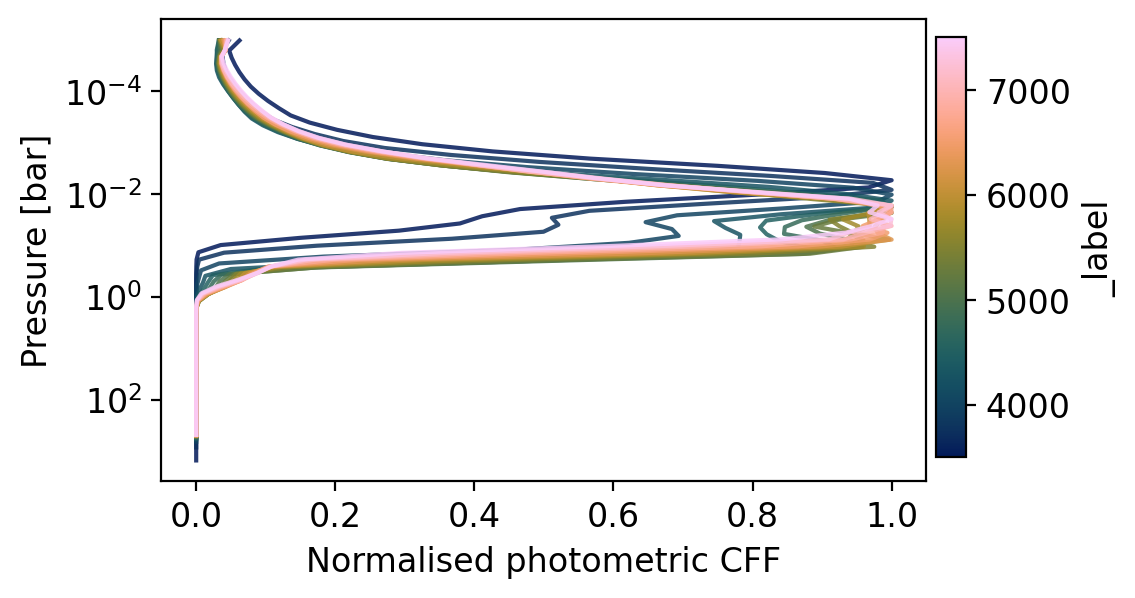

In [43]:
fig,ax = plt.subplots(1,1,  figsize=(5,3))

al = 0.85
wlmin = 1.0
wlmax = 10.0

# cmap and scalar mappable
if cbar_scl == "symlog":
    linthresh = indep_min / 1e1
    if linthresh == 0:
        linthresh = indep_max / 1e6
    norm = mpl.colors.SymLogNorm(vmin=0, vmax=indep_max, linthresh=linthresh)

elif cbar_scl == "log":
    norm = mpl.colors.LogNorm(vmin=indep_min, vmax=indep_max)

else:
    norm = mpl.colors.Normalize(vmin=indep_min, vmax=indep_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# plot emission spectra
for i in range(npoints):

    # check if this case satisfies control variables
    plot_this = True
    for k in control_vars.keys(): # for each control var
        ctrl_val = lg.descend_get(conf[i],k)
        ctrl_exp = control_vars[k]

        # compare against control var
        if isinstance(ctrl_exp, float):
            plot_this = plot_this and np.isclose(ctrl_exp, ctrl_val)
        else:
            plot_this = plot_this and (ctrl_exp == ctrl_val)

    # skip if does not satisfy controls
    if not plot_this:
        continue

    # get data
    dat = post[i]
    atm = atms[i]
    lbl = lg.descend_get(conf[i],indep_var)
    col = sm.to_rgba(float(lbl))
    ls = 'solid'

    # pressure
    y = np.array(atm["p"]) * 1e-5
    nlev_c = len(y)

    # wavelength
    x = np.abs(dat["bandmax"] + dat["bandmin"]) * 0.5 * 1e6
    w = np.abs(dat["bandmax"] - dat["bandmin"]) * 1e6

    # range
    imin = np.argmin(np.abs(x - wlmin))
    imax = np.argmin(np.abs(x - wlmax))

    # integrate over band
    cf_phot = np.zeros(nlev_c)
    for i in range(nlev_c):
        cf_phot[i] = np.dot(dat["contfunc"][i,imin:imax] , w[imin:imax])
    cf_phot /= np.amax(cf_phot)

    # get maximum
    cf_imax = np.argmax(cf_phot)
    cf_pmax = y[cf_imax]

    # plot this cff
    ax.plot(cf_phot,y, linestyle=ls, c=col, zorder=i*2, alpha=al, label=lbl)

# decorate plot
if len(indep_unique) > 3:
    lg.add_cbar(fig, sm, width=0.03, squeeze=0.90, tick_format="%g")
else:
    lg.make_legend(ax, set_color=None, title=indep_lbl)

ax.set_xlabel("Normalised photometric CFF")

ax.set_ylabel("Pressure [bar]")
ax.set_yscale("log")
ax.invert_yaxis()

plt.show()